###  1. Import required libraries

In [1]:
!pip install --user tensorflow

In [3]:
!pip install tensorflow --upgrade --quiet

In [5]:
import sys
!{sys.executable} -m pip install --user tensorflow

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [9]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [11]:
pip install openpyxl


Note: you may need to restart the kernel to use updated packages.


### 2. Load the Excel file

In [14]:
data = pd.read_excel('customer_churn.xlsx')

### 3. Basic EDA

In [17]:
print("First 5 rows of the dataset:\n", data.head())
print("\nData info:\n")
data.info()
print("\nSummary statistics:\n", data.describe())
print("\nMissing values:\n", data.isnull().sum())

First 5 rows of the dataset:
    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV Stream

### 4. Drop unnecessary columns

In [20]:
if 'customerID' in data.columns:
    data.drop('customerID', axis=1, inplace=True)

In [22]:
print(data.columns.tolist())

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


### 5. Handle missing values

In [25]:
data.fillna(method='ffill', inplace=True)

### 6. Encode categorical variables

In [28]:
categorical_cols = data.select_dtypes(include='object').columns.drop('Churn', errors='ignore')

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))


### 7. Correlation heatmap

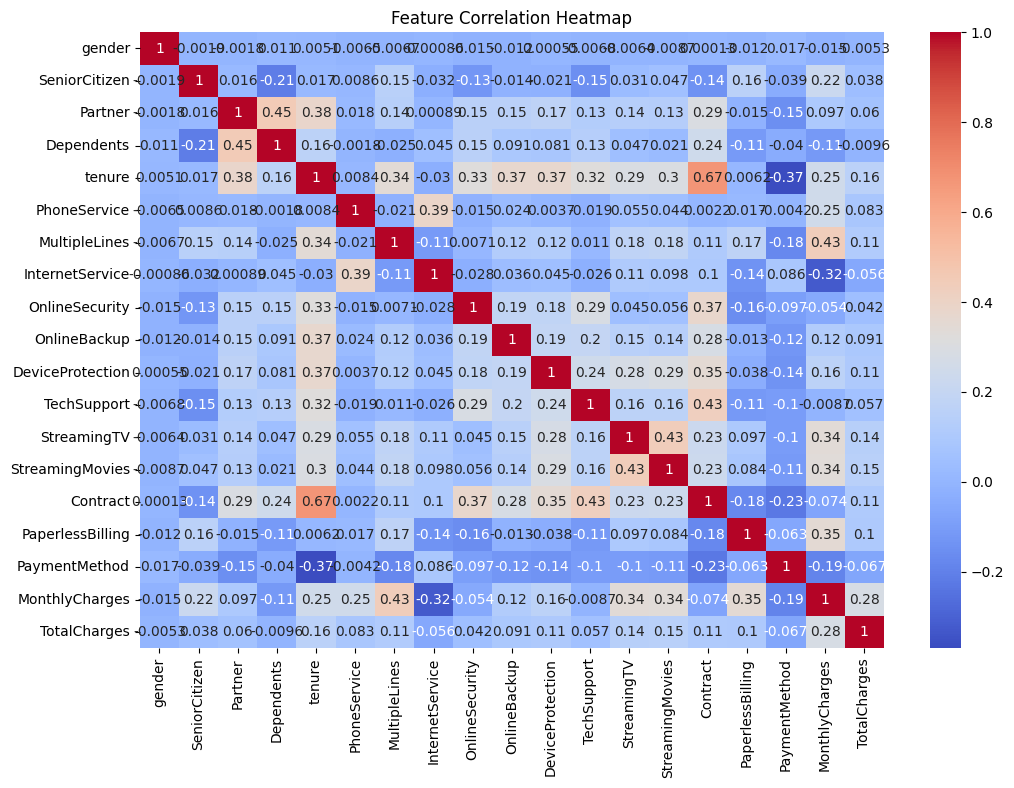

In [31]:
plt.figure(figsize=(12, 8))
numeric_data = data.select_dtypes(include=[np.number])
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


#  Data Manipulation 
### Task a: Total male customers

In [34]:
df = data.copy()
male_count = df[df['gender'] == 1].shape[0]
print(f"Total male customers: {male_count}\n")

Total male customers: 3555



### Task b: Customers with DSL internet service

In [37]:
dsl_count = df[df['InternetService'] == 0].shape[0]
print(f"DSL customers: {dsl_count}\n")

DSL customers: 2421



### Task c: Female senior citizens with mailed check payment

In [40]:
gender_value = 0
payment_value = 3
new_customer = df[
    (df['gender'] == gender_value) & 
    (df['SeniorCitizen'] == 1) & 
    (df['PaymentMethod'] == payment_value)
]
print(f"Female senior citizens with mailed check: {new_customer.shape[0]}\n")

Female senior citizens with mailed check: 50



### Task d: Tenure <10 or TotalCharges <500

In [43]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)
new_customer = df[(df['tenure'] < 10) | (df['TotalCharges'] < 500)]
print(f"Customers with tenure<10 or charges<500: {new_customer.shape[0]}\n")


Customers with tenure<10 or charges<500: 2286



# Data Visualization

### Task a: Churn pie chart

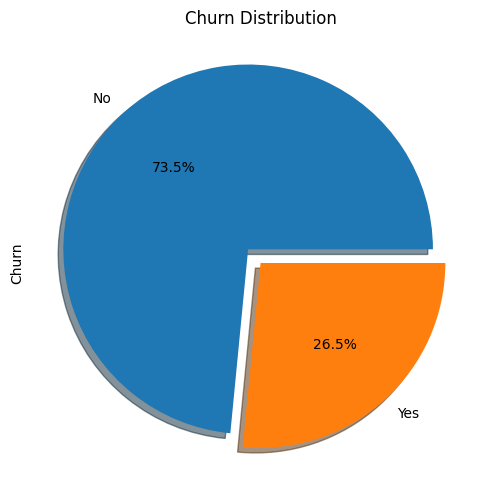

In [47]:
plt.figure(figsize=(6,6))
df['Churn'].value_counts().plot.pie(autopct='%1.1f%%', explode=[0.1,0], shadow=True)
plt.title('Churn Distribution')
plt.show()

### Task b: Internet service bar plot

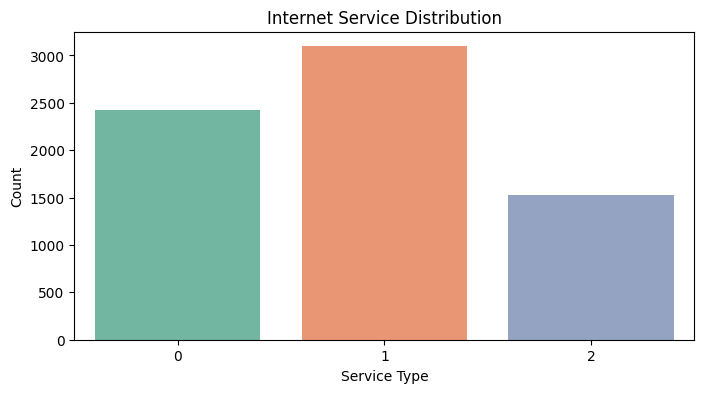

In [50]:
plt.figure(figsize=(8,4))
sns.countplot(x='InternetService', data=df, palette='Set2')
plt.title('Internet Service Distribution')
plt.xlabel('Service Type')
plt.ylabel('Count')
plt.show()

# Model Building 


Model 1 Results:


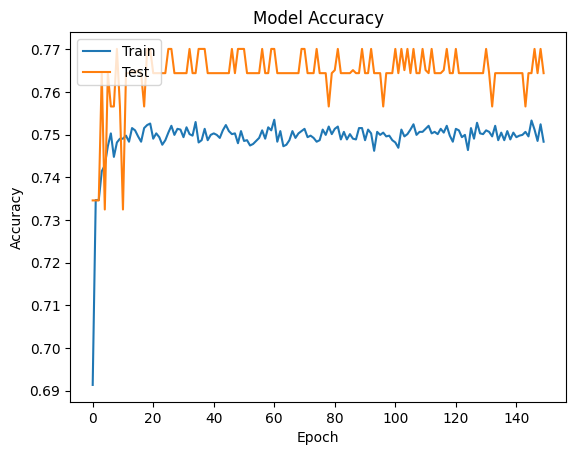

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Confusion Matrix:
 [[966  69]
 [263 111]]

Model 2 Results:


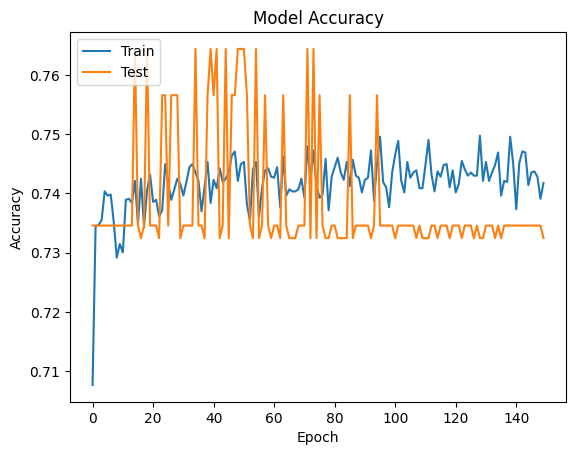

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Confusion Matrix:
 [[1032    3]
 [ 374    0]]

Model 3 Results:


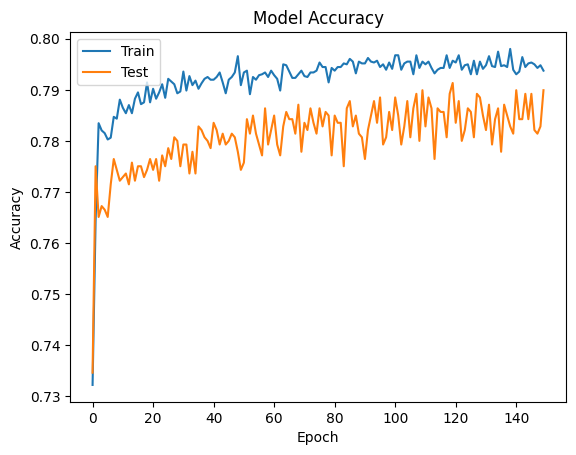

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Confusion Matrix:
 [[956  79]
 [217 157]]


In [53]:
from tensorflow.keras.layers import Input  # Already imported earlier if needed

# Encode target column 'Churn'
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])

def prepare_data(features):
    X = df[features]
    y = df['Churn']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

def build_and_evaluate_model(X_train, X_test, y_train, y_test, input_dim, dropout_layers=False):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(12, activation='relu'))
    
    if dropout_layers:
        model.add(Dropout(0.3))
        
    model.add(Dense(8, activation='relu'))
    
    if dropout_layers:
        model.add(Dropout(0.2))
        
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=150, 
                        validation_data=(X_test, y_test), verbose=0)
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    y_pred = (model.predict(X_test) > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    return cm

# Task C.a: Model 1 (Only tenure)
print("\nModel 1 Results:")
X_train, X_test, y_train, y_test = prepare_data(['tenure'])
cm1 = build_and_evaluate_model(X_train, X_test, y_train, y_test, input_dim=1)
print("Confusion Matrix:\n", cm1)

# Task C.b: Model 2 (With dropout)
print("\nModel 2 Results:")
cm2 = build_and_evaluate_model(X_train, X_test, y_train, y_test, input_dim=1, dropout_layers=True)
print("Confusion Matrix:\n", cm2)

# Task C.c: Model 3 (Three features)
print("\nModel 3 Results:")
X_train, X_test, y_train, y_test = prepare_data(['tenure', 'MonthlyCharges', 'TotalCharges'])
cm3 = build_and_evaluate_model(X_train, X_test, y_train, y_test, input_dim=3)
print("Confusion Matrix:\n", cm3)
